# 1. The Quantum Approximate Optimization Algorithm (QAOA)

## Overview

In this tutorial notebook, we will explore the **Quantum Approximate Optimization Algorithm (QAOA)** and how it can be used to solve combinatorial optimization problems like the infamous NP-hard Max-Cut problem. 

### What is QAOA?

QAOA is a hybrid quantum-classical algorithm that combines:
- **Variational Quantum circuits** to prepare trial quantum states with high probability of measuring good solutions
- **Classical optimization** to find the best parameters for these circuits

The algorithm works by:
1. Encoding the optimization problem as a quantum Hamiltonian
2. Preparing parameterized quantum states using alternating layers
3. Measuring expectation values and using classical optimization to improve parameters
4. Iterating until convergence

### Why Max-Cut?

Even though Max-Cut does not have a plethora of real-world applications, it is a solid starting position for optimization because:
- It's a well-understood NP-hard problem
- It has a clear quantum formulation
- Results are easy to visualize and verify
- It serves as a benchmark for quantum algorithms

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Optimization modeling library
from luna_quantum import Linear, Model, Quadratic, Variable, Vtype, Solution

# Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer.primitives import SamplerV2

# Classical optimization
from scipy.optimize import minimize

# Utils
from utils import pretty

## Max-Cut Problem and the Petersen Graph

### Problem Definition

Let us begin by formulating the **Max-Cut problem**, a graph $G(V, E)$ separation problem that aims to assign the nodes of a graph into **two disjoint sets**. 

**Objective**: Maximize the number of edges between nodes assigned to different sets.

### Mathematical Formulation

The typical formulation of Max-Cut relies on spin variables, since they are easily translated to Ising Hamiltonians and used by QAOA. When we assign a spin variable to each qubit, the product of two connected node variables will tell us whether a cut has occured or not. Formally $s_u s_v = \pm1$, where $s_u s_v = +1$ means $u$ and $v$ belong to the same group (no cut), or $s_u s_v = -1$, belong to separate groups (cut occurs). As a consequence, minimizing
$$ \underset{s}{\arg\min} \sum_{(u,v) \in E} s_u s_v$$
will find the maximum cut for the input graph.

Since spin variables are not particularily common in classical optimization, we use binary variables $x_v \in \{0, 1\}$ to describe the node assignment of vertex $v$:
- $x_v = 0$: vertex $v$ belongs to set A (colored blue in visualizations)
- $x_v = 1$: vertex $v$ belongs to set B (colored orange in visualizations)

To resemble the Max-Cut objective formulated with spin variables, we want for edge $(u, v)$:
- **No contribution** (0) if nodes are in the same set: $x_u = x_v$ and the *edge is not cut*.
- A **negative contribution** (-1) if nodes are in disjunct sets: $x_u \neq x_v$ and the *edge is cut*.

This can be achieved through the construction: $2x_u x_v - x_u - x_v$

**Verification**:
- When $x_u = x_v = 0$: $2(0)(0) - (0) - (0)  = 0$
- When $x_u = x_v = 1$: $2(1)(1) - (1) - (1)  = 0$  
- When $x_u \neq x_v$: $2(0)(1) - (0) - (1) = -1$ or $2(1)(0) - (1) - (0) = -1$

Thus, the objective can be phrased as a **minimization** (which is standard for optimization libraries):
$$\underset{x}{\arg \min} \sum_{(u, v) \in E} (2 x_u x_v - x_u - x_v)$$

---

### The Petersen Graph

We now define the **Petersen graph**, a famous graph in graph theory, for which we want to find the Max-Cut using QAOA. The Petersen graph:
- Has 10 vertices and 15 edges
- Is highly symmetric
- Serves as a counterexample to many graph theory conjectures
- Has a known maximum cut value of 9

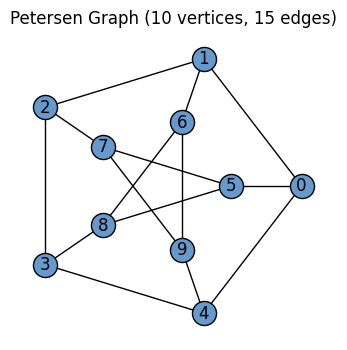

Graph properties:
Number of vertices: 10
Number of edges: 15


In [2]:
# Create and visualize the Petersen graph
fig, ax = plt.subplots(figsize=(4, 4))
plt.axis("off")

# Generate the Petersen graph using NetworkX
G = nx.petersen_graph()

# Create a shell layout for better visualization
# The Petersen graph has a natural structure with an outer pentagon and inner star
layout = nx.shell_layout(G, [range(5, 10), range(5)], rotate=0)

# Draw the graph with blue nodes and black edges
nx.draw(G, layout, node_color="#69C", edgecolors="k")
nx.draw_networkx_labels(G, layout)

plt.title("Petersen Graph (10 vertices, 15 edges)")
plt.show()

print("Graph properties:")
print(f"Number of vertices: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

### Define the Optimization Model

The **luna_quantum** package features a Rust-accelerated modeling framework that allows us to define optimization problems in a clean, mathematical way. We now define the Max-Cut Problem as an `luna_quantum.Model`.

**Key steps**:
1. Create binary variables for each vertex
2. Add the objective function terms for each edge
3. The model automatically handles the mathematical formulation

In [3]:
# Create the optimization model for Max-Cut
model = Model("MaxCut")

with model.environment:
    # Create a binary variable for every node in the graph
    # x[i] = 0 means node i is in set A, x[i] = 1 means node i is in set B
    x = [Variable(f"x_{i}") for i in G.nodes]
    # The equivalent spin variable formulation way would
    # s = [Variable(f"s_{i}", vtype=Vtype.Spin) for i in G.nodes]

# TASK: Implement the objective function for the optimization problem.
# For each edge (i,j), we want to add the term: 2*x[i]*x[j] - x[i] - x[j]
# This gives +1 when nodes are in different sets, -1 when in same set

##TASK>
for i, j in G.edges():
    # Add the Max-Cut objective term for this edge
    # The mathematical formulation ensures we get +1 for cut edges, -1 for uncut edges
    model.objective += 2 * x[i] * x[j] - x[i] - x[j]
##<TASKEND

# The equivalent spin variable formulation would be
# for i, j in G.edges():
#     model.objective += s[i] * s[j]

print(model)

Model: MaxCut
Minimize
  2 * x_0 * x_1 + 2 * x_0 * x_4 + 2 * x_0 * x_5 + 2 * x_1 * x_2 + 2 * x_1 * x_6 
  + 2 * x_2 * x_3 + 2 * x_2 * x_7 + 2 * x_3 * x_4 + 2 * x_3 * x_8 
  + 2 * x_4 * x_9 + 2 * x_5 * x_7 + 2 * x_5 * x_8 + 2 * x_6 * x_8 
  + 2 * x_6 * x_9 + 2 * x_7 * x_9 - 3 * x_0 - 3 * x_1 - 3 * x_2 - 3 * x_3 
  - 3 * x_4 - 3 * x_5 - 3 * x_6 - 3 * x_7 - 3 * x_8 - 3 * x_9
Binary
  x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9


## QAOA Quantum Circuit Construction

### Understanding QAOA Layers

QAOA works by applying alternating layers of two types of operations:

1. **Cost Layer** (Problem Hamiltonian $H_C$): Encodes the optimization problem
   - Controlled by parameter $\gamma$ 
   - Applies phase factor based on the objective function terms
   - For Max-Cut: positive phase factor for same assignments and a negative one for opposing

2. **Mixer Layer** (Mixer Hamiltonian $H_M$): Provides probability transfer
   - Controlled by parameter $\beta$
   - Usually implemented as X-rotations on all qubits
   - Allows for constructive interference of good quality solutions (boost in probability).

### Circuit Structure

For $p$ layers, the QAOA ansatz is:
$$|\psi(\beta, \gamma)\rangle = e^{-i\beta_p H_M} e^{-i\gamma_p H_C} \cdots e^{-i\beta_1 H_M} e^{-i\gamma_1 H_C} |+\rangle^{\otimes n}$$

where $|+\rangle^{\otimes n}$ is the equal superposition state (all qubits in $|+\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$).

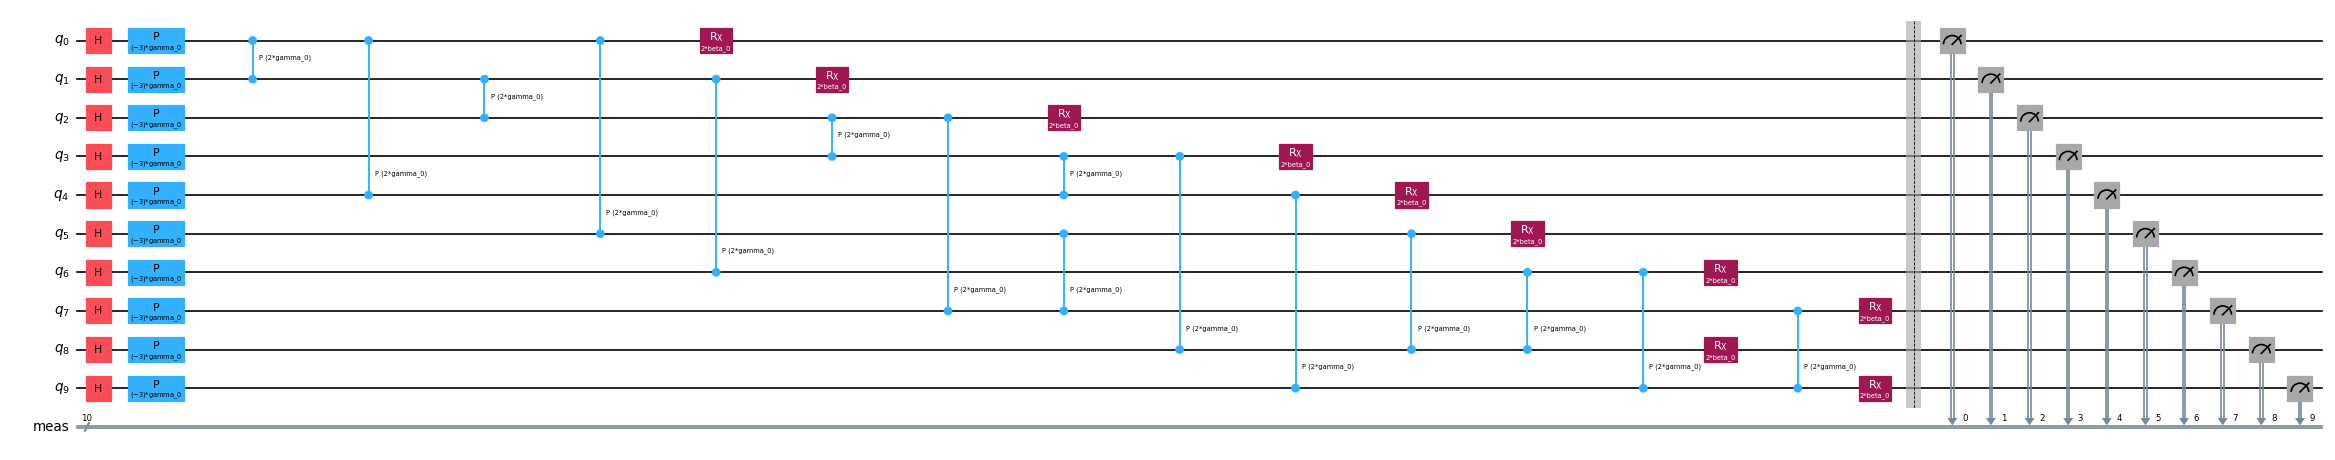

In [4]:
def qaoa_layer(
    model: Model, beta: Parameter | float, gamma: Parameter | float
) -> QuantumCircuit:
    """Implements a single QAOA layer consisting of cost and mixer operations.

    Args:
        model: The optimization model containing the objective function
        beta: Mixer parameter (controls X-rotations)
        gamma: Cost parameter (controls problem-specific rotations)

    Returns:
        QuantumCircuit: A single QAOA layer
    """
    # Quantum circuit with one qubit per variable
    qc = QuantumCircuit(len(model.variables()))

    # Mapping from variables to qubit indices
    varmap = {v: i for i, v in enumerate(model.variables())}

    # COST LAYER: Apply rotations based on objective function terms
    ##TASK>
    for item, val in model.objective.items():
        angle = val * gamma
        match item:
            case Linear(v):
                # Linear terms: single-qubit phase gate
                qc.p(angle, varmap[v])
            case Quadratic(v1, v2):
                # Quadratic terms: two-qubit controlled-phase gate applied to |11>
                qc.cp(angle, varmap[v1], varmap[v2])
    ##<TASKEND

    # MIXER LAYER: Apply X-rotations to all qubits
    ##TASK>
    qc.rx(2 * beta, qc.qubits)
    ##<TASKEND

    return qc


# Equivalent cost function implementation for spin variables
# def qaoa_layer_spin(
#     model: Model, beta: Parameter | float, gamma: Parameter | float
# ) -> QuantumCircuit:
#     """Implements a single QAOA layer consisting of cost and mixer operations.
#
#     Args:
#         model: The optimization model containing the objective function
#         beta: Mixer parameter (controls X-rotations)
#         gamma: Cost parameter (controls problem-specific rotations)
#
#     Returns:
#         QuantumCircuit: A single QAOA layer
#     """
#     # Quantum circuit with one qubit per variable
#     qc = QuantumCircuit(len(model.variables()))
#     # Mapping from variables to qubit indices
#     varmap = {v: i for i, v in enumerate(model.variables())}
#
#     for item, val in model.objective.items():
#         match item:
#             case Quadratic(v1, v2):
#
#                 qc.rzz(-2 * val * gamma, varmap[v1], varmap[v2])
#
#
#     qc.rx(2 * beta, qc.qubits)
#
#     return qc


def qaoa_circ(model: Model, num_reps: int = 1) -> QuantumCircuit:
    """Generates a complete QAOA circuit with specified number of layers.

    Args:
        model: The optimization model
        num_reps: Number of QAOA layers (p parameter)

    Returns:
        QuantumCircuit: Complete QAOA circuit with measurements
    """
    # Verify the model is suitable for QAOA
    assert model.num_constraints == 0, "QAOA requires unconstrained problems"
    assert all(v.vtype == Vtype.Binary for v in model.variables()), (
        "All variables must be binary"
    )

    # Initialize quantum circuit
    qc = QuantumCircuit(len(model.variables()))

    # Start with equal superposition state |+⟩^⊗n
    qc.h(qc.qubits)

    # Create parameter templates for a single layer
    beta = Parameter("beta")
    gamma = Parameter("gamma")
    layer_circ = qaoa_layer(model, beta, gamma)

    # Create individual parameters for each layer
    betas = [Parameter(f"beta_{p}") for p in range(num_reps)]
    gammas = [Parameter(f"gamma_{p}") for p in range(num_reps)]

    # Add all QAOA layers
    for beta_p, gamma_p in zip(betas, gammas):
        # Substitute the template parameters with layer-specific ones
        layer_instance = layer_circ.assign_parameters({beta: beta_p, gamma: gamma_p})
        qc = qc.compose(layer_instance)

    # Add measurements to all qubits
    qc.measure_all()
    return qc


# Test the circuit construction
test_circuit = qaoa_circ(model, num_reps=1)
test_circuit.draw("mpl", scale=0.6, fold=90)

## Classical Optimization Loop

### The Optimization Process

1. **Parameter Initialization**: Start with random or heuristic parameter values. In our case, we set all variables to 0.25
2. **Quantum Execution**: Run the parameterized circuit and collect measurement samples
3. **Cost Evaluation**: Calculate the expectation value of the objective function
4. **Classical Update**: Use classical optimization to update parameters
5. **Iteration**: Repeat until convergence

### Cost Function

The cost function we're minimizing is:
$$f(\beta, \gamma) = \langle \psi(\beta, \gamma) | H_C | \psi(\beta, \gamma) \rangle$$

where $H_C$ is the cost Hamiltonian encoding our Max-Cut problem.

Let's construct the helper functions for sampling and evaluating the expectation value:

In [5]:
sampler = SamplerV2()


def sample(model: Model, qc: QuantumCircuit, x: np.ndarray, shots=1000):
    """Execute quantum circuit and evaluate the objective function.

    Args:
        model: Optimization model
        qc: Parameterized quantum circuit
        x: Parameter values [beta_0, beta_1, ..., gamma_0, gamma_1, ...]
        shots: Number of quantum measurements

    Returns:
        Solution object with samples and objective values
    """
    # Assign parameter values and execute circuit
    qc_assigned = qc.assign_parameters({p: v for p, v in zip(qc.parameters, x)})
    pub = (qc_assigned,)
    result = sampler.run([pub], shots=shots).result()

    # Convert measurement results to binary arrays
    # Note: Qiskit returns results in reverse bit order
    counts = result[0].data.meas.get_counts()

    # Convert to optimization Aqarios solution format
    sol = Solution.from_counts(counts, model=model)

    # Evaluate the objective function for all samples
    return model.evaluate(sol)


def cost_function(
    x: np.ndarray, model: Model, qc: QuantumCircuit, logs: list | None = None
):
    """Cost function for classical optimization.

    This function is called repeatedly by the classical optimizer.

    Args:
        x: Current parameter values
        model: Optimization model
        qc: Quantum circuit
        logs: Optional list to store optimization history

    Returns:
        float: Expected value of the objective function
    """
    # Get quantum measurement results and evaluate objective
    sol = sample(model, qc, x)

    # Calculate expectation value (average objective value across all samples)
    energy = sol.expectation_value()

    # Log the approximation ration if logging is enabled
    if logs is not None:
        logs.append(energy / -12)

    return energy

## Running QAOA for Different Circuit Depths

### Effect of Circuit Depth (p parameter)

The **p parameter** determines the number of QAOA layers:

### Trade-offs
- **Higher p**: Better approximation quality, more complex optimization landscape
- **Lower p**: Faster execution, easier optimization, but potentially lower quality, (maybe even success on current-days hardware)

### Optimization Strategy
We use the **COBYLA** (Constrained Optimization BY Linear Approximation) algorithm:
- Derivative-free optimization (good for noisy quantum cost functions)
- Handles the optimization landscape well
- Initial parameters set to 0.25 (Constant or Ramp initialization of QAOA parameters work best from experience)

### Expected Results
- **Optimal value**: -9 (corresponding to cut value of 9)
 **Quality**: Higher p should achieve better approximation ratios

=== Running optimization for p=1 layers ===
Circuit depth: 13, Parameters: 2
Iteration 5: Energy = 0.861
Iteration 10: Energy = 0.866
Iteration 15: Energy = 0.866
-------------------------
Final energy: -10.421
Best cut value: 12.0
Optimization success: True

=== Running optimization for p=2 layers ===
Circuit depth: 21, Parameters: 4
Iteration 5: Energy = 0.886
Iteration 10: Energy = 0.882
-------------------------
Final energy: -10.723
Best cut value: 12.0
Optimization success: True

=== Running optimization for p=3 layers ===
Circuit depth: 29, Parameters: 6
Iteration 5: Energy = 0.896
Iteration 10: Energy = 0.892
Iteration 15: Energy = 0.893
Iteration 20: Energy = 0.897
-------------------------
Final energy: -10.832
Best cut value: 12.0
Optimization success: True


=== Final Results ===
Best cut value achieved: 12.0
Theoretical optimum: 9
Approximation ratio: 1.190


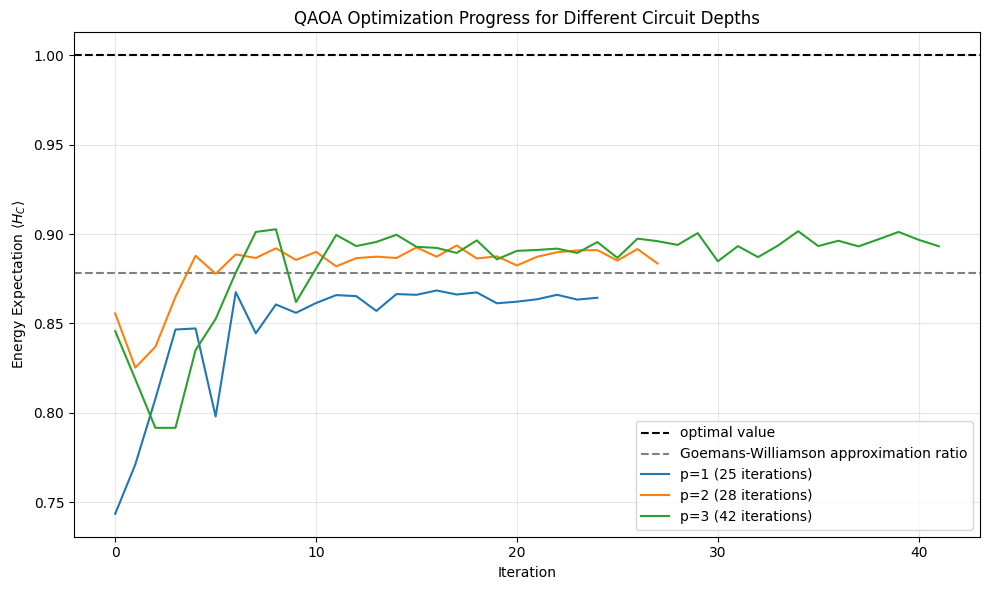

In [6]:
best = None
final_solution = None
all_logs = {}

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.axhline(1, color="k", linestyle="dashed", label="optimal value")
ax.axhline(
    0.878,
    color="gray",
    linestyle="dashed",
    label="Goemans-Williamson approximation ratio",
)
ax.set_xlabel("Iteration")
ax.set_ylabel(r"Energy Expectation $\langle H_C \rangle$")
ax.set_title("QAOA Optimization Progress for Different Circuit Depths")
plt.draw()

# Run QAOA for different numbers of layers
for p in range(1, 4):
    print(f"=== Running optimization for p={p} layers ===")

    current_it = 1

    def progress_callback(*args):
        """Callback function to print optimization progress."""
        global current_it
        if current_it % 5 == 0:
            print(f"Iteration {current_it}: Energy = {all_logs[p][-1]:.3f}")
        current_it += 1

    # Create QAOA circuit with p layers
    circ = qaoa_circ(model, p)
    all_logs[p] = []

    print(f"Circuit depth: {circ.depth()}, Parameters: {len(circ.parameters)}")

    # Run classical optimization
    initial_params = [0.25] * (2 * p)  # p beta parameters + p gamma parameters

    result = minimize(
        cost_function,  # Function to minimize
        initial_params,  # Initial parameters
        args=(model, circ, all_logs[p]),  # Additional arguments
        method="COBYLA",  # Optimization algorithm
        options={"rhobeg": 0.1},  # COBYLA-specific options
        callback=progress_callback,  # Progress monitoring
    )

    # Plot the optimization trajectory
    ax.plot(all_logs[p], label=f"p={p} ({len(all_logs[p])} iterations)")

    final_solution = sample(model, circ, result.x)
    best = final_solution.best()

    print("-------------------------")
    print(f"Final energy: {result.fun:.3f}")
    print(f"Best cut value: {-best.obj_value}")
    print(f"Optimization success: {result.success}")
    print()


print("\n=== Final Results ===")
print(f"Best cut value achieved: {-best.obj_value}")
print("Theoretical optimum: 9")
print(f"Approximation ratio: {(-final_solution.expectation_value()) / 9:.3f}")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();

## Results Analysis

In [7]:
pretty(final_solution)

x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
1,0,1,0,0,0,0,0,1,1
0,1,0,0,1,0,0,1,1,0
0,0,1,0,1,1,1,0,0,0
1,0,1,0,1,0,1,1,1,0
1,0,0,1,0,0,1,1,0,0
1,1,0,1,0,0,0,1,1,1
0,1,0,1,0,1,0,0,0,1
0,1,0,1,1,1,1,1,0,0
0,1,1,0,1,1,0,0,1,1
1,0,1,1,0,1,1,0,0,1


### Understanding the Distribution

The histogram below shows the distribution of objective values obtained from the quantum measurements. This gives us insight into:

1. **Peak location**: Where most samples concentrate
2. **Spread**: How consistent the algorithm is
3. **Optimal samples**: How often we find the best solutions


Remember: Since we're minimizing, more negative values are better!

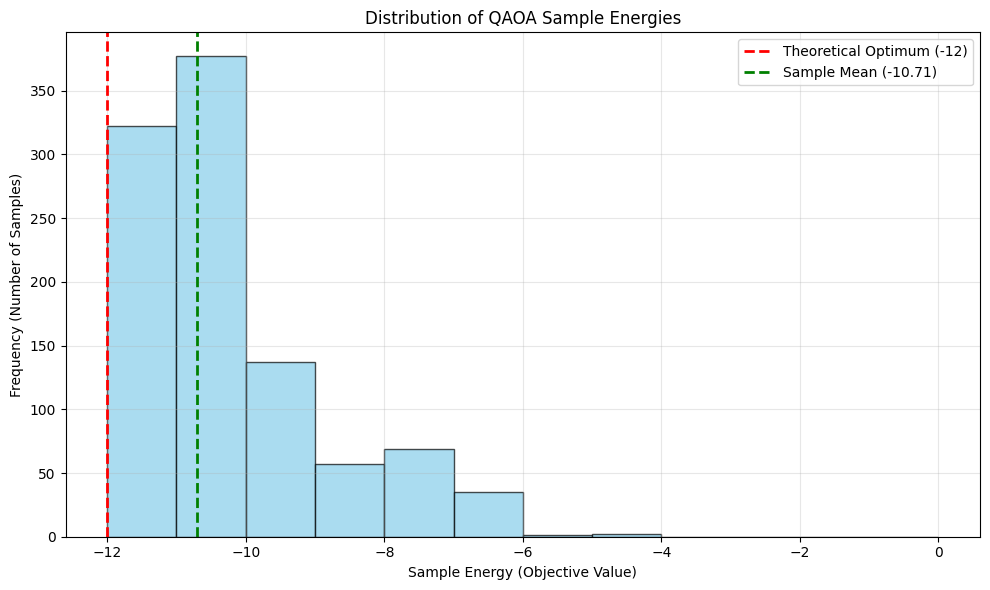

=== Sample Distribution Analysis ===
Best sample energy: -12.0
Best cut value: 12.0
Mean sample energy: -10.707
Total samples: 1000
Samples achieving optimum: 322 (32.2%)


In [8]:
# Analyze the final solution distribution
fig, ax = plt.subplots(figsize=(10, 6))

# Create histogram of objective values weighted by their frequency
ax.hist(
    final_solution.obj_values,
    weights=final_solution.counts,
    bins=range(-12, 1, 1),
    alpha=0.7,
    color="skyblue",
    edgecolor="black",
)

ax.set_xlabel("Sample Energy (Objective Value)")
ax.set_ylabel("Frequency (Number of Samples)")
ax.set_title("Distribution of QAOA Sample Energies")

# Mark the optimal value
ax.axvline(
    -12, color="red", linestyle="dashed", linewidth=2, label="Theoretical Optimum (-12)"
)

# Add some statistics to the plot
mean_energy = np.average(final_solution.obj_values, weights=final_solution.counts)
ax.axvline(
    mean_energy,
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Sample Mean ({mean_energy:.2f})",
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print distribution statistics
print("=== Sample Distribution Analysis ===")
print(f"Best sample energy: {best.obj_value}")
print(f"Best cut value: {-best.obj_value}")
print(f"Mean sample energy: {mean_energy:.3f}")
print(f"Total samples: {sum(final_solution.counts)}")

# Count how many samples achieved the optimal value
optimal_samples = sum(
    count
    for energy, count in zip(final_solution.obj_values, final_solution.counts)
    if energy == -12
)
print(
    f"Samples achieving optimum: {optimal_samples} ({100 * optimal_samples / sum(final_solution.counts):.1f}%)"
)

## Solution Visualization

### Interpreting the Max-Cut Solution

Now let's visualize the best solution found by QAOA. In the graph below:

- **Blue nodes**: Vertices assigned to set A (x = 0)
- **Orange nodes**: Vertices assigned to set B (x = 1)
- **Solid black edges**: Connect vertices in the same set (not cut)
- **Dashed red edges**: Connect vertices in different sets (**cut edges**)


### Graph Theory Insight
The Petersen graph is vertex-transitive and has high symmetry, which means multiple optimal solutions exist. QAOA might find different optimal cuts in different runs.

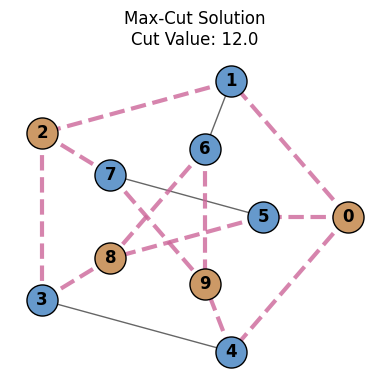


=== Solution Analysis ===
Cut value: 12.0
Number of cut edges: 12
Number of uncut edges: 3
Total edges: 15
Set A vertices: [1, 3, 4, 5, 6, 7]
Set B vertices: [0, 2, 8, 9]
Set A size: 6
Set B size: 4

🎉 Excellent! Found solution better than Goemanns-Williamson (ratio: 0.892)


In [9]:
ig, ax = plt.subplots(figsize=(4, 4))
plt.axis("off")

# Draw edges that are NOT cut (vertices in same set) - solid black lines
uncut_edges = [(u, v) for u, v in G.edges if best.sample[u] == best.sample[v]]
nx.draw_networkx_edges(
    G, layout, edgelist=uncut_edges, edge_color="black", width=1, alpha=0.6
)

# Draw edges that ARE cut (vertices in different sets) - dashed red lines
cut_edges = [(u, v) for u, v in G.edges if best.sample[u] != best.sample[v]]
nx.draw_networkx_edges(
    G, layout, edgelist=cut_edges, edge_color="#C69", width=3, style="dashed", alpha=0.8
)

set_A = [i for i in range(G.number_of_nodes()) if not best.sample[i]]
nx.draw_networkx_nodes(
    G, layout, nodelist=set_A, node_color="#69C", edgecolors="k", node_size=500
)

set_B = [i for i in range(G.number_of_nodes()) if best.sample[i]]
nx.draw_networkx_nodes(
    G, layout, nodelist=set_B, node_color="#C96", edgecolors="k", node_size=500
)

nx.draw_networkx_labels(G, layout, font_size=12, font_weight="bold")

plt.title(f"Max-Cut Solution\nCut Value: {-best.obj_value}")

plt.tight_layout()
plt.show()

# Print solution analysis
print("\n=== Solution Analysis ===")
print(f"Cut value: {-best.obj_value}")
print(f"Number of cut edges: {len(cut_edges)}")
print(f"Number of uncut edges: {len(uncut_edges)}")
print(f"Total edges: {G.number_of_edges()}")
print(f"Set A vertices: {sorted(set_A)}")
print(f"Set B vertices: {sorted(set_B)}")
print(f"Set A size: {len(set_A)}")
print(f"Set B size: {len(set_B)}")

# Performance assessment
approximation_ratio = (-final_solution.expectation_value()) / 12
if approximation_ratio >= 0.878:
    print(
        f"\n🎉 Excellent! Found solution better than Goemanns-Williamson (ratio: {approximation_ratio:.3f})"
    )
else:
    print(f"\n📈 Room for improvement (ratio: {approximation_ratio:.3f})")
    print(
        "   Try increasing the number of QAOA layers or adjusting optimization parameters"
    )

### What We've Accomplished

In this tutorial, we successfully:

1. **Formulated** the Max-Cut problem as a quantum optimization problem
2. **Implemented** the QAOA algorithm with parameterized quantum circuits
3. **Optimized** the circuit parameters using hybrid quantum-classical optimization
4. **Analyzed** the results and visualized the solution

### Real Quantum Hardware

To run this on actual quantum computers:
```python
# Example for IBM Quantum
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as RuntimeSampler

service = QiskitRuntimeService()
backend = service.backend("ibm_aachen")  # or another backend
sampler = RuntimeSampler(backend)
```

**Hardware considerations:**
- Connectivity constraints may require circuit transpilation
- Noise will affect results; error mitigation techniques may help
- Shorter circuits (smaller $p$) often work better on NISQ devices

---

## 🎉 Congratulations!

You've successfully completed this tutorial! We hope you found it helpful and informative.

### 📖 References & Further Reading
This tutorial was built upon the following resources:

- Farhi et al., 2014: A Quantum Approximate Optimization Algorithm [[Paper]](https://arxiv.org/abs/1411.4028)

### 🚀 Coming Up Next

In the [next tutorial](02_PenaltyTerms.ipynb), we will discuss constrained optimization problems and reformulate them to an unconstrained format.

---
## 💡 Ready to dive deeper?

Explore more tutorials, documentation, and resources to accelerate your journey

<img src="https://docs.aqarios.com/assets/aqarios.png#only-light" width="400px" alt="Aqarios Logo" />

[![Website](https://img.shields.io/badge/🌐_Website-Visit_Aqarios.com-blue?style=for-the-badge)](https://www.aqarios.com)
[![Documentation](https://img.shields.io/badge/📚_Documentation-Explore_Docs-green?style=for-the-badge)](https://docs.aqarios.com)
[![LinkedIn](https://img.shields.io/badge/🤝_LinkedIn-Connect_With_Us-0077B5?style=for-the-badge&logo=linkedin)](https://www.linkedin.com/company/aqarios-gmbh/)


**What's Next?**

- **Explore our documentation** for advanced features and best practices
- **Join our community** on LinkedIn for updates and discussions  
- **Check out more tutorials** to expand your skills

### 💬 Need Help?

Have questions or feedback about this tutorial? We'd love to hear from you! Connect with us through any of the links above.

---

<div align="center">
<small>

Tutorial provided by Aqarios GmbH | © 2025 Aqarios GmbH | Made with ❤️ for developers

</small>
</div>